Contrairement au notebook, nous allons essayer de faire une classification multiclasse

In [1]:
%%time

SEED=42

import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import roc_curve, classification_report, confusion_matrix
from sklearn.metrics import f1_score, make_scorer

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

CPU times: user 2.88 s, sys: 1.1 s, total: 3.97 s
Wall time: 3.66 s


In [2]:
train = pd.read_csv('data/train.csv', index_col=0)
test = pd.read_csv('data/test.csv', index_col=0)

In [3]:
train.shape, test.shape

((1235, 28), (824, 27))

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1235 entries, 0 to 1234
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   object 
 1   age                    1235 non-null   object 
 2   hospital_number        1235 non-null   int64  
 3   rectal_temp            1235 non-null   float64
 4   pulse                  1235 non-null   float64
 5   respiratory_rate       1235 non-null   float64
 6   temp_of_extremities    1196 non-null   object 
 7   peripheral_pulse       1175 non-null   object 
 8   mucous_membrane        1214 non-null   object 
 9   capillary_refill_time  1229 non-null   object 
 10  pain                   1191 non-null   object 
 11  peristalsis            1215 non-null   object 
 12  abdominal_distention   1212 non-null   object 
 13  nasogastric_tube       1155 non-null   object 
 14  nasogastric_reflux     1214 non-null   object 
 15  nasogastr

On observe une grande majorité de features catégorielles

In [5]:
train.describe()

,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3
count,1.235000e+03,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000
mean,9.545004e+05,38.202186,79.574089,30.054251,4.382591,49.602429,21.388016,3.290931,3832.496356,14.612146,3.577328
std,1.356403e+06,0.788668,29.108638,16.452066,1.937357,10.535800,26.676453,1.589195,5436.733774,193.705735,88.858953
min,5.213990e+05,35.400000,30.000000,8.000000,1.000000,23.000000,3.500000,0.100000,0.000000,0.000000,0.000000
25%,5.288000e+05,37.800000,53.000000,18.000000,2.000000,43.000000,6.600000,2.000000,2205.000000,0.000000,0.000000
50%,5.297770e+05,38.200000,76.000000,28.000000,4.500000,48.000000,7.500000,3.000000,2209.000000,0.000000,0.000000
75%,5.341450e+05,38.600000,100.000000,36.000000,6.000000,57.000000,9.100000,4.300000,3205.000000,0.000000,0.000000
max,5.305129e+06,40.800000,184.000000,96.000000,7.500000,75.000000,89.000000,10.100000,41110.000000,3112.000000,2209.000000


In [6]:
train.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
id,,,,,,,,,,,,,,,,,,,,,
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [7]:
train['outcome'].value_counts()

outcome
lived         574
died          410
euthanized    251
Name: count, dtype: int64

On a ici des catégories pas proportionelles, on risque d'avoir quelques soucis pour bien prédire les euthanasies

In [8]:
train_lived_died = train.copy()
train_lived_died.outcome = train_lived_died.outcome.apply(lambda x: 'dead' if x == 'died' or x == 'euthanized' else x)

In [9]:
# train_dead_eutha = train[train['outcome']!='lived']
# train_dead_eutha.shape

La personne a choisi de regrouper les catégories died et euthanized car cette dernière est sous représentée et les deux correspondent à des chevaux morts et sont donc assez proches

Potentiellement ajouter ici des graphs de viz

In [10]:
labelencoder = preprocessing.LabelEncoder()

In [11]:
train_encoded = train.copy()
object_columns = train_encoded.select_dtypes(include='object').columns

for i in object_columns:
    labels = train_encoded[i]
    labels_id = labelencoder.fit_transform(labels)
    train_encoded[i] = labels_id

In [12]:
train

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
id,,,,,,,,,,,,,,,,,,,,,
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,yes,adult,535246,38.5,129.0,48.0,cool,reduced,pale_pink,more_3_sec,...,57.0,66.0,serosanguious,2.0,yes,2206,0,0,no,lived
1231,yes,adult,528570,37.5,60.0,50.0,cool,reduced,pale_cyanotic,less_3_sec,...,35.0,6.4,serosanguious,3.6,yes,2209,0,0,yes,died
1232,yes,young,529685,37.5,84.0,40.0,normal,reduced,normal_pink,less_3_sec,...,40.0,5.9,cloudy,7.0,yes,400,0,0,yes,lived


In [13]:
# idem pour alive vs dead
train_lived_died_encoded = train_lived_died.copy()
train_lived_died_columns = train_lived_died_encoded.select_dtypes(include='object').columns

for i in train_lived_died_columns:
    labels = train_lived_died_encoded[i]
    labels_id = labelencoder.fit_transform(labels)
    train_lived_died_encoded[i] = labels_id

In [14]:
# même chose pour test
# test_object_columns = test.select_dtypes(include='object').columns

# for i in test_object_columns:
#     labels = test[i]
#     labels_id = labelencoder.fit_transform(labels)
#     test[i] = labels_id


<Axes: >

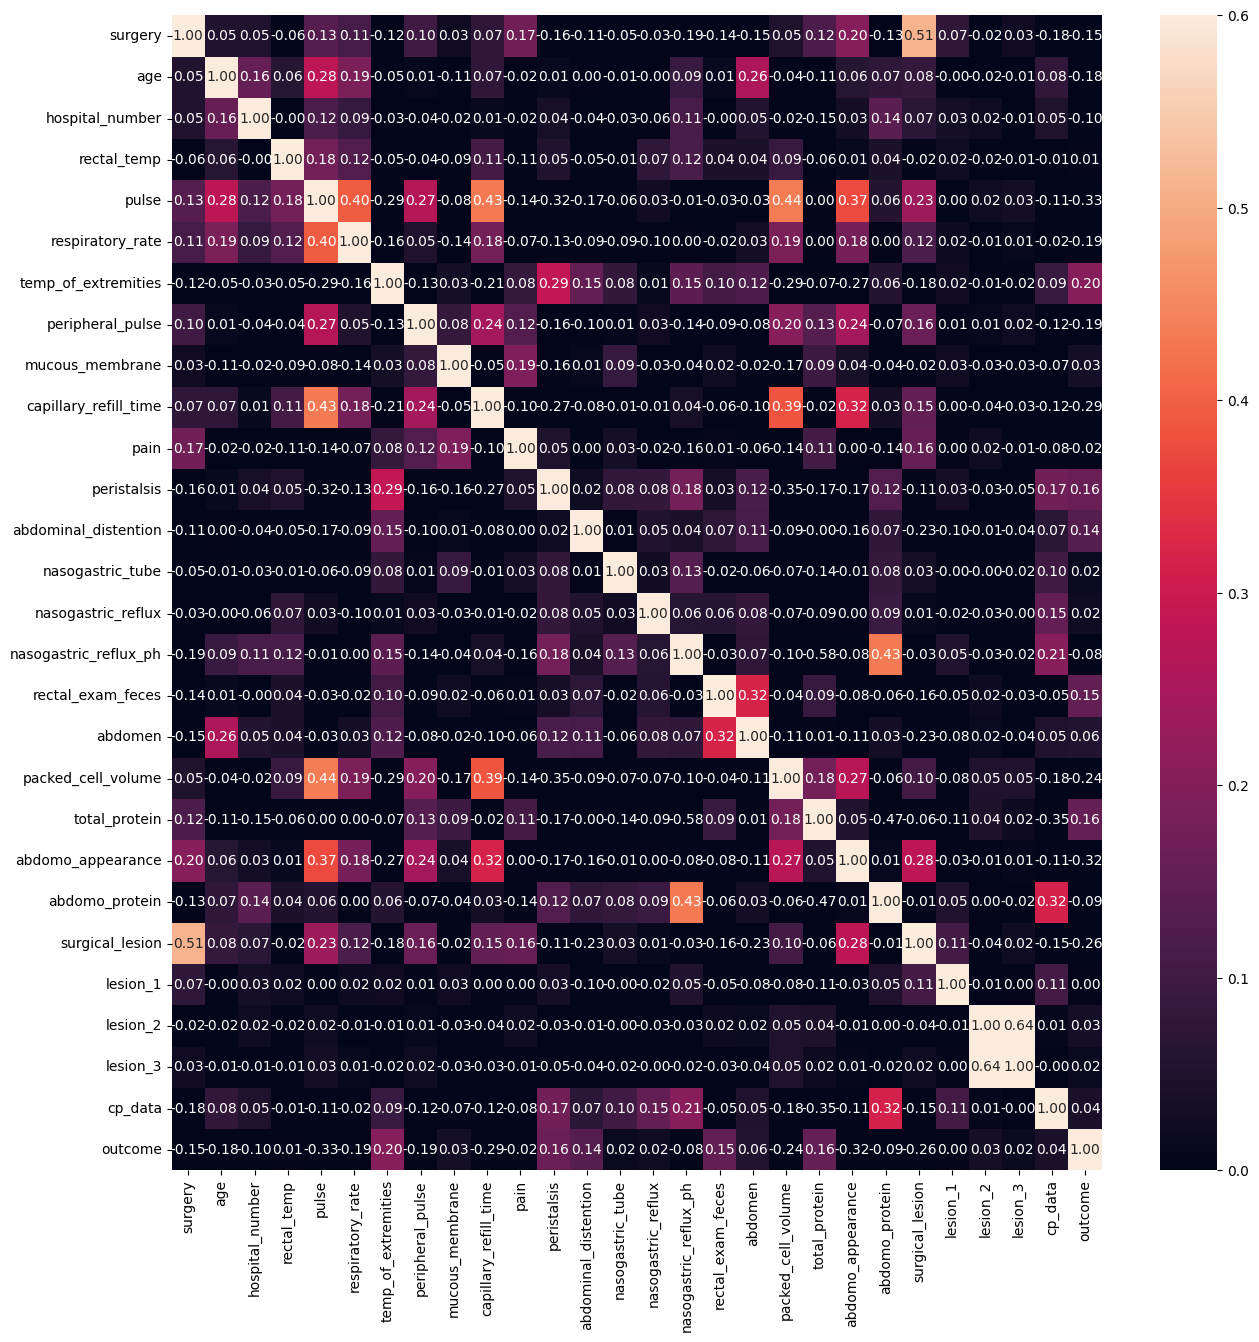

In [15]:
fig,ax = plt.subplots(figsize=(15,15))
sns.heatmap(train_encoded.corr(), annot=True, fmt=".2f", ax=ax, vmin=0, vmax=0.6)

<Axes: >

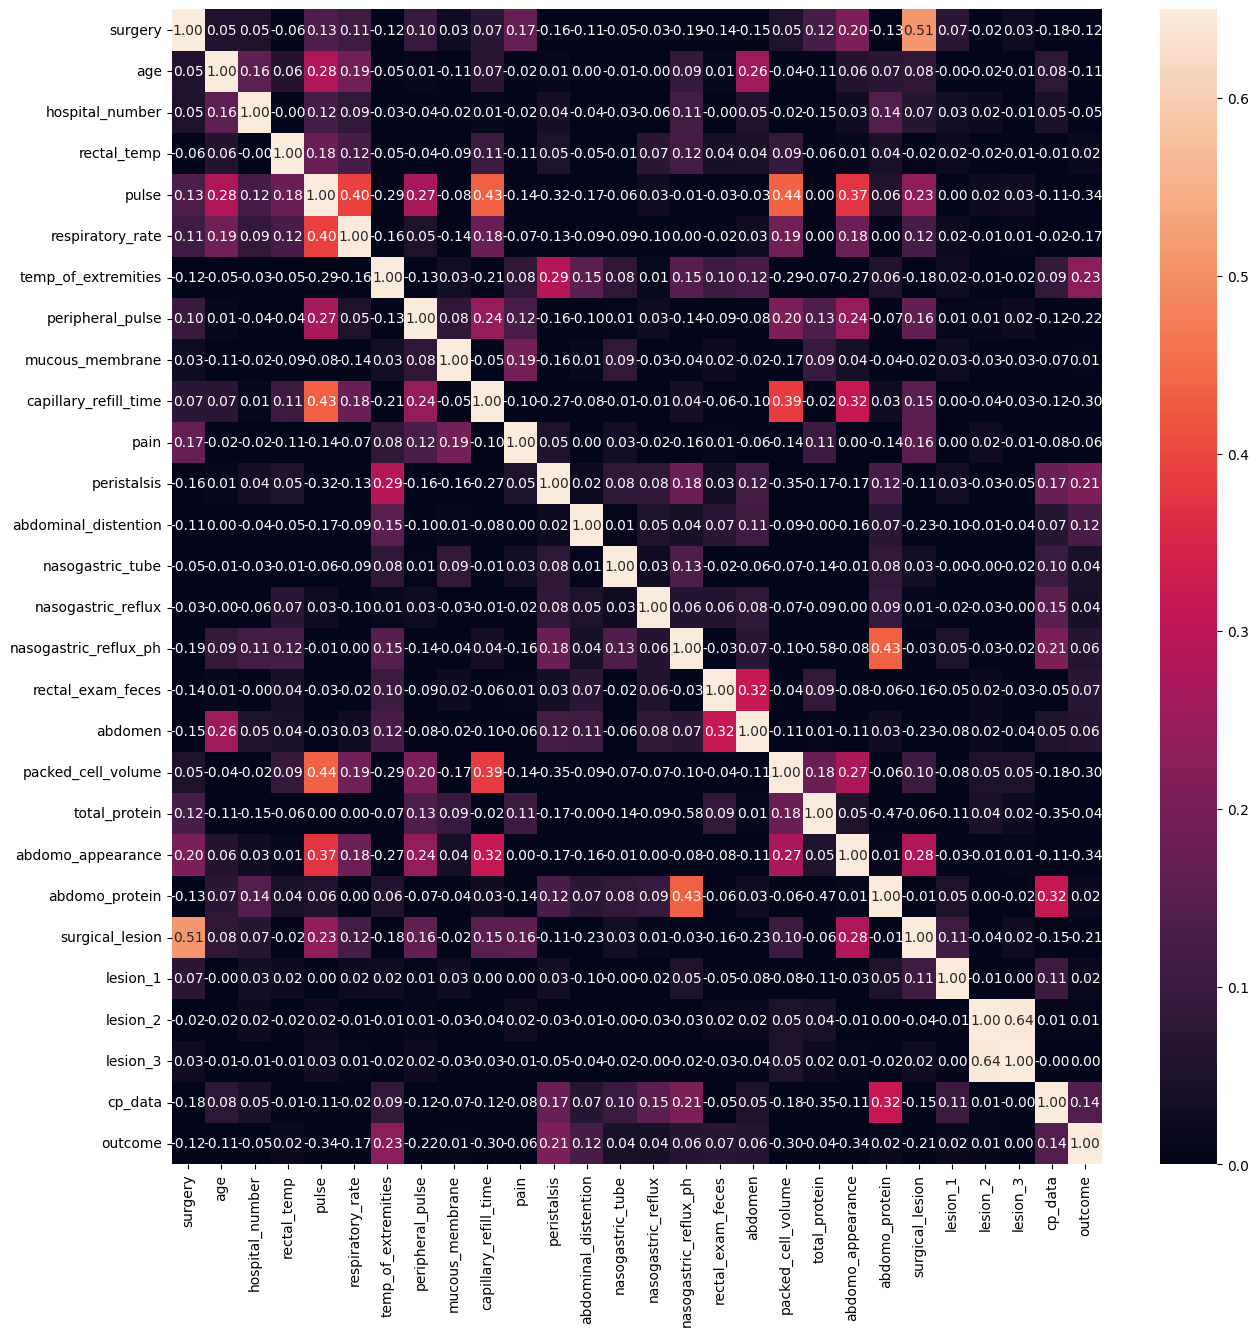

In [16]:
# on regarde s'il y a une différence si on prend notre deuxième train
fig,ax = plt.subplots(figsize=(15,15))
sns.heatmap(train_lived_died_encoded.corr(), annot=True, fmt=".2f", ax=ax, vmin=0, vmax=0.65)

Les deux qui ressortent bien dans les deux cas sont temp_of_extremities et peristalsis

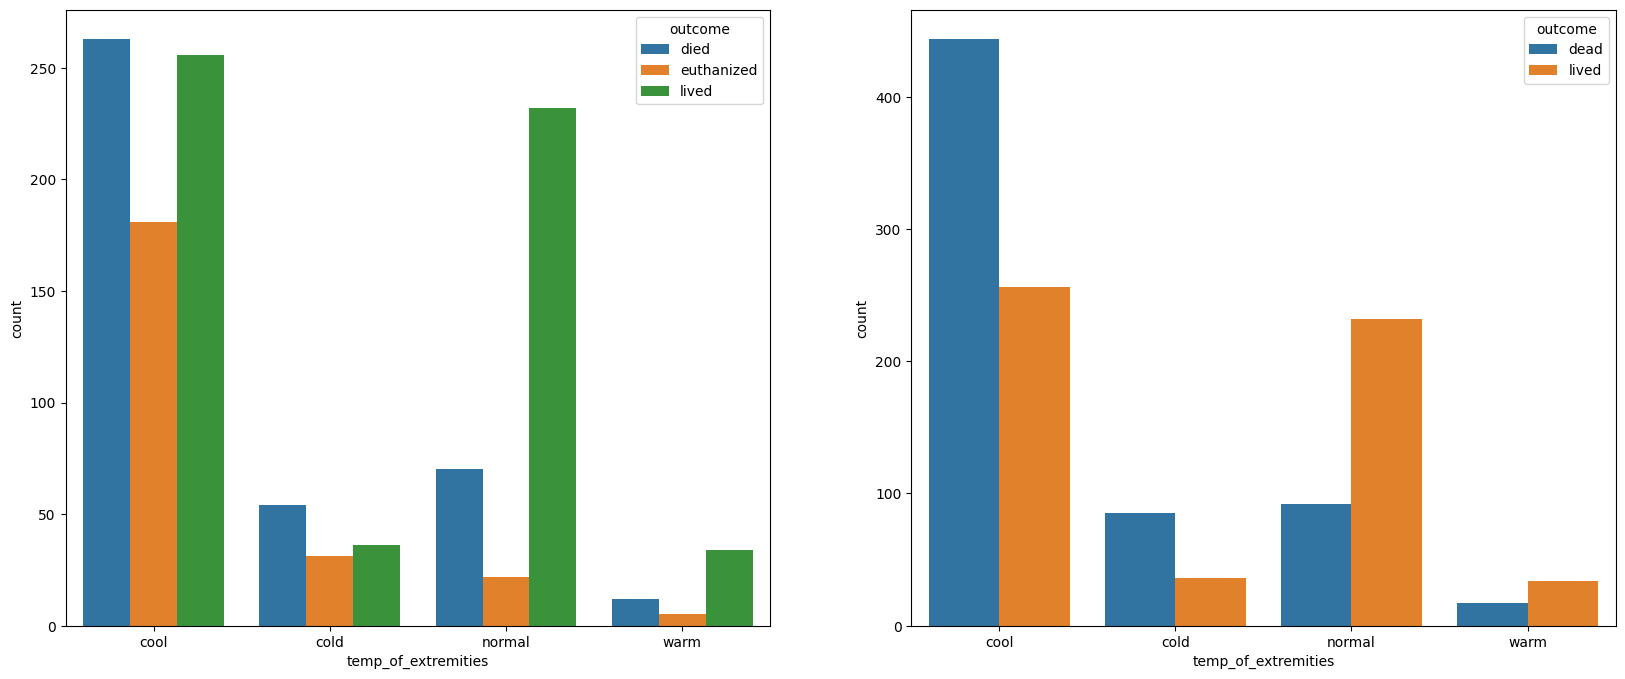

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
sns.countplot(data=train, x="temp_of_extremities", hue="outcome", ax=ax1)
sns.countplot(data=train_lived_died, x="temp_of_extremities", hue="outcome", ax=ax2)
plt.show()

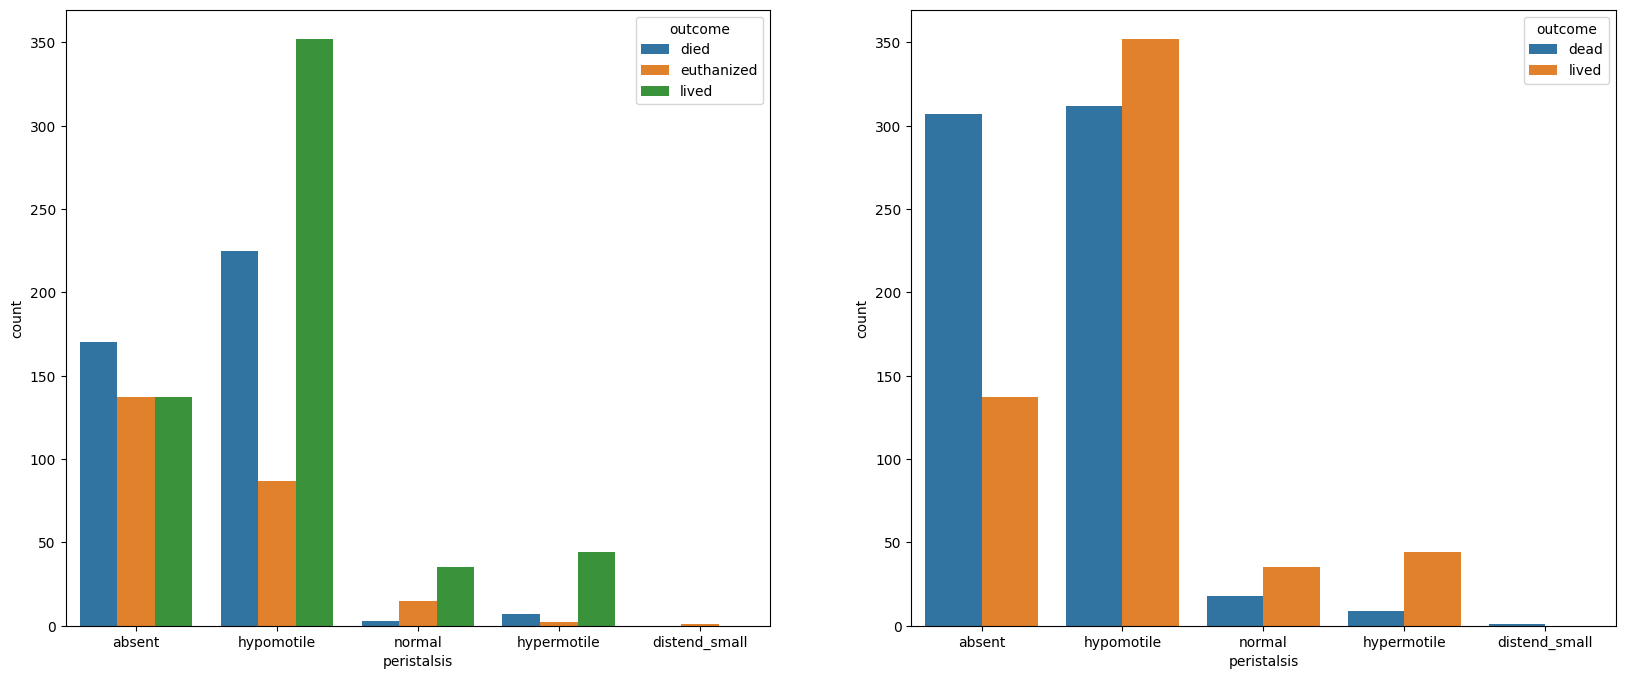

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
sns.countplot(data=train, x="peristalsis", hue="outcome", ax=ax1)
sns.countplot(data=train_lived_died, x="peristalsis", hue="outcome", ax=ax2)
plt.show()

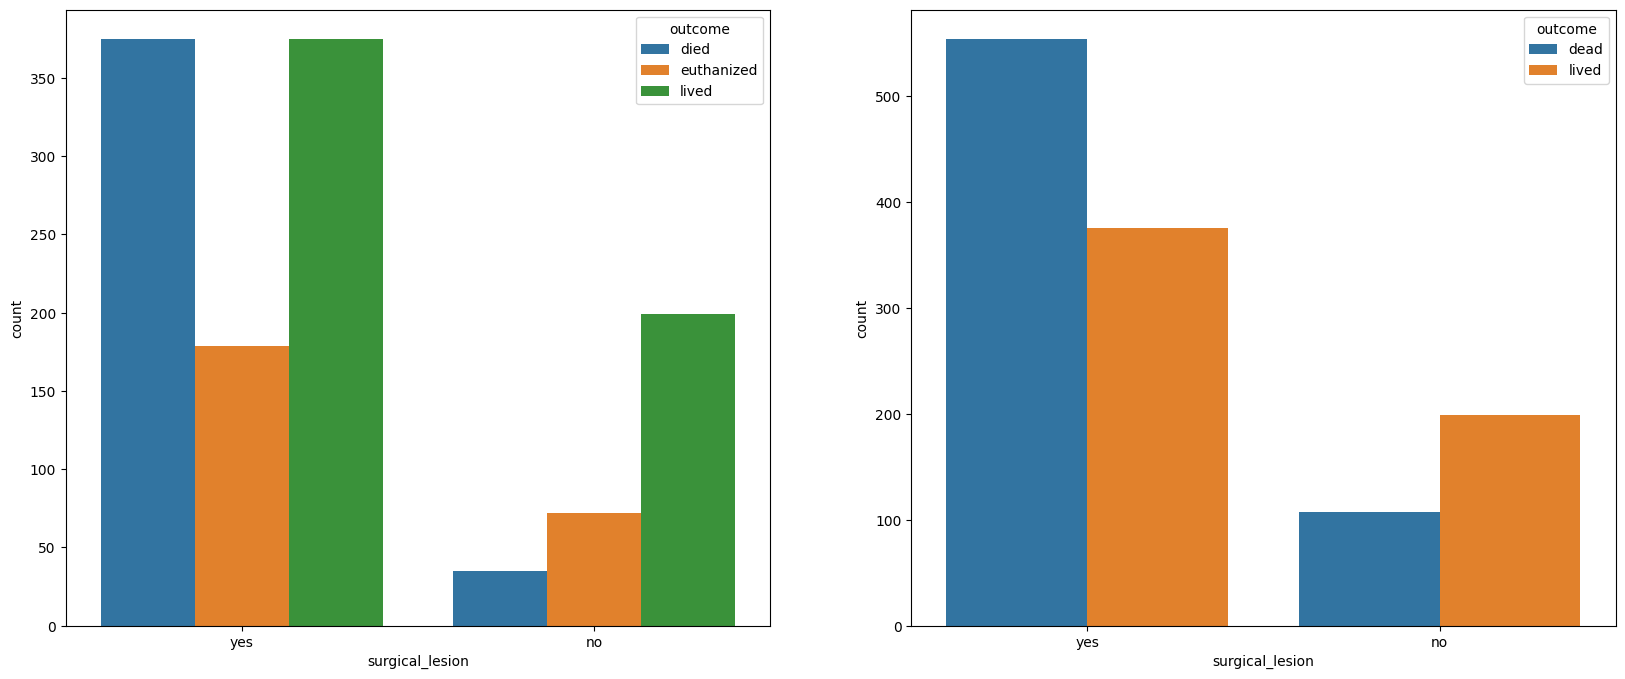

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
sns.countplot(data=train, x="surgical_lesion", hue="outcome", ax=ax1)
sns.countplot(data=train_lived_died, x="surgical_lesion", hue="outcome", ax=ax2)
plt.show()

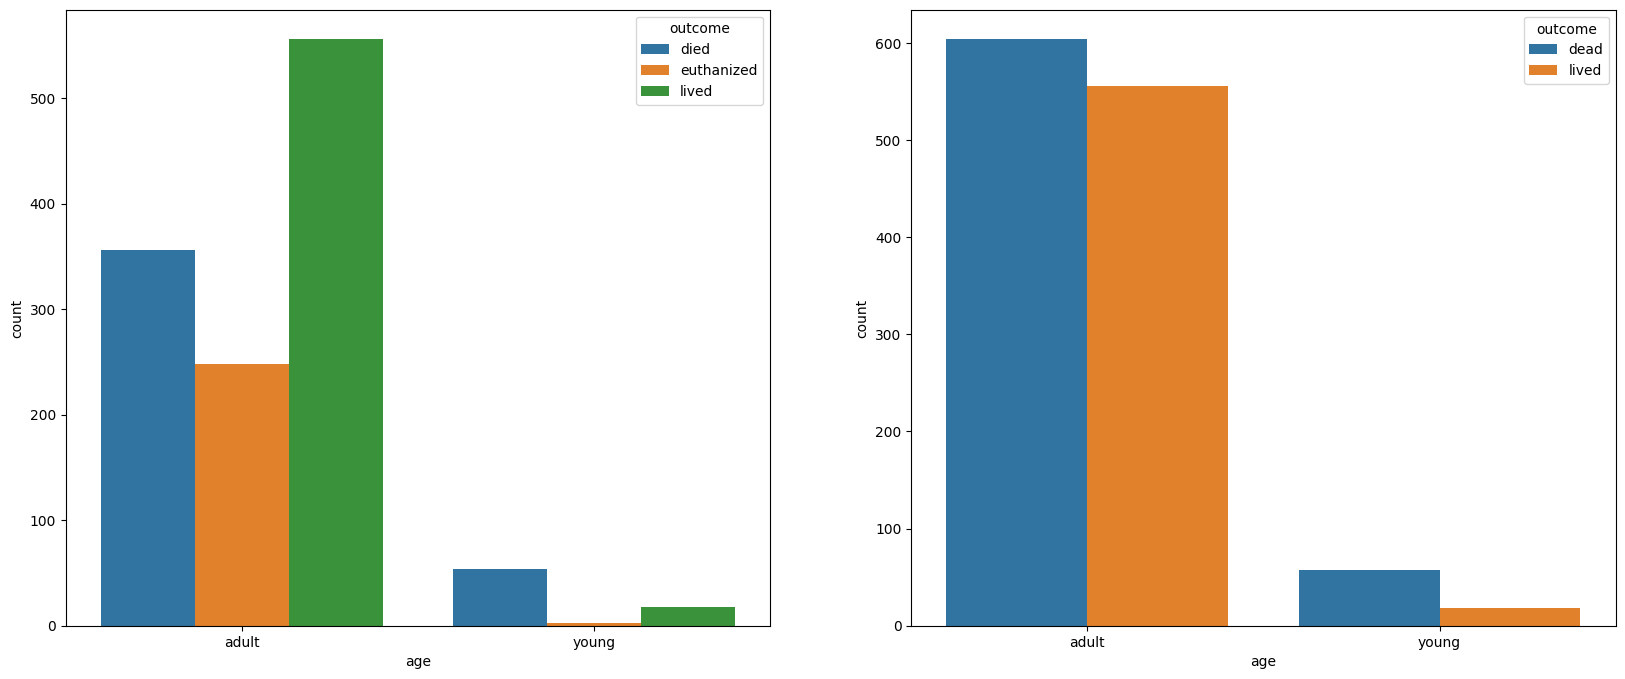

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
sns.countplot(data=train, x="age", hue="outcome", ax=ax1)
sns.countplot(data=train_lived_died, x="age", hue="outcome", ax=ax2)
plt.show()

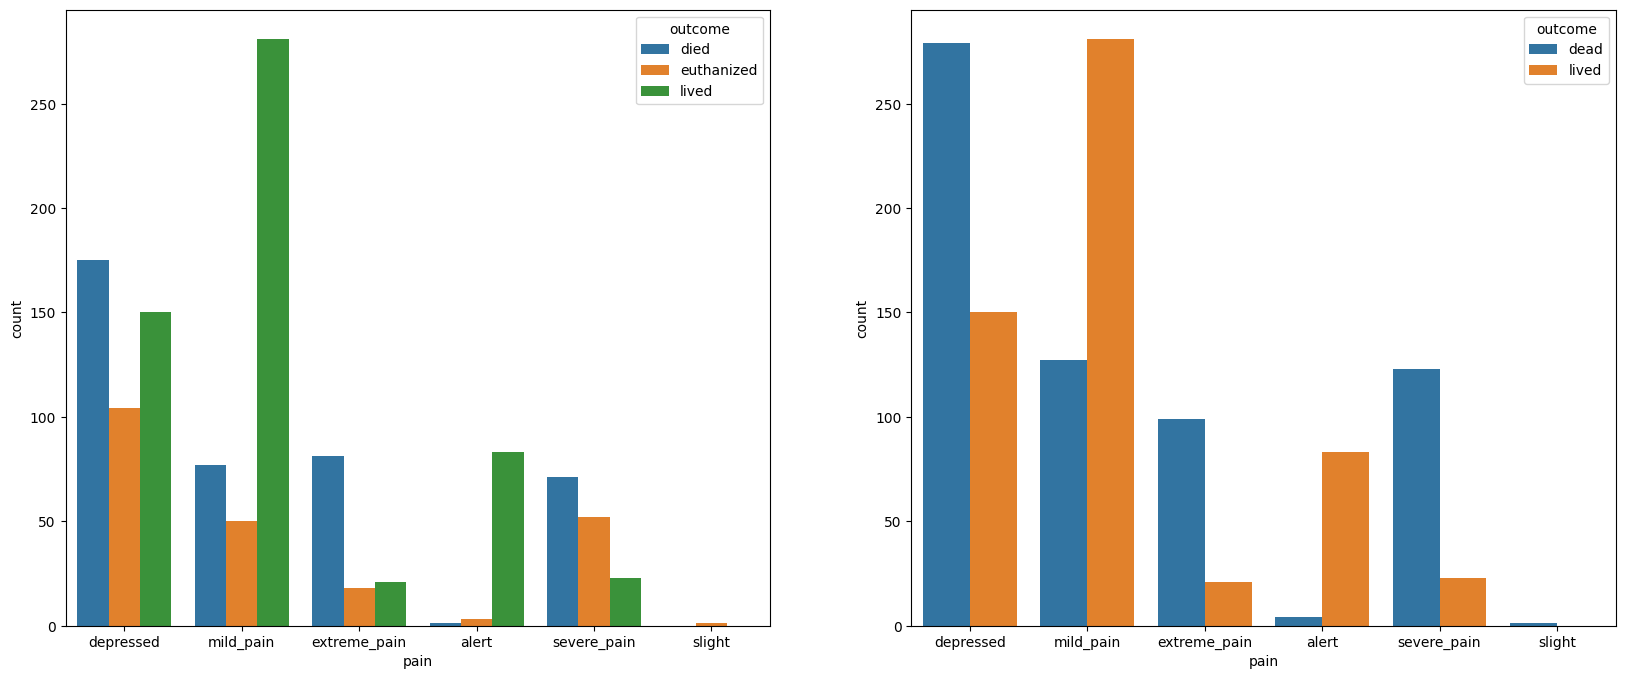

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
sns.countplot(data=train, x="pain", hue="outcome", ax=ax1)
sns.countplot(data=train_lived_died, x="pain", hue="outcome", ax=ax2)
plt.show()

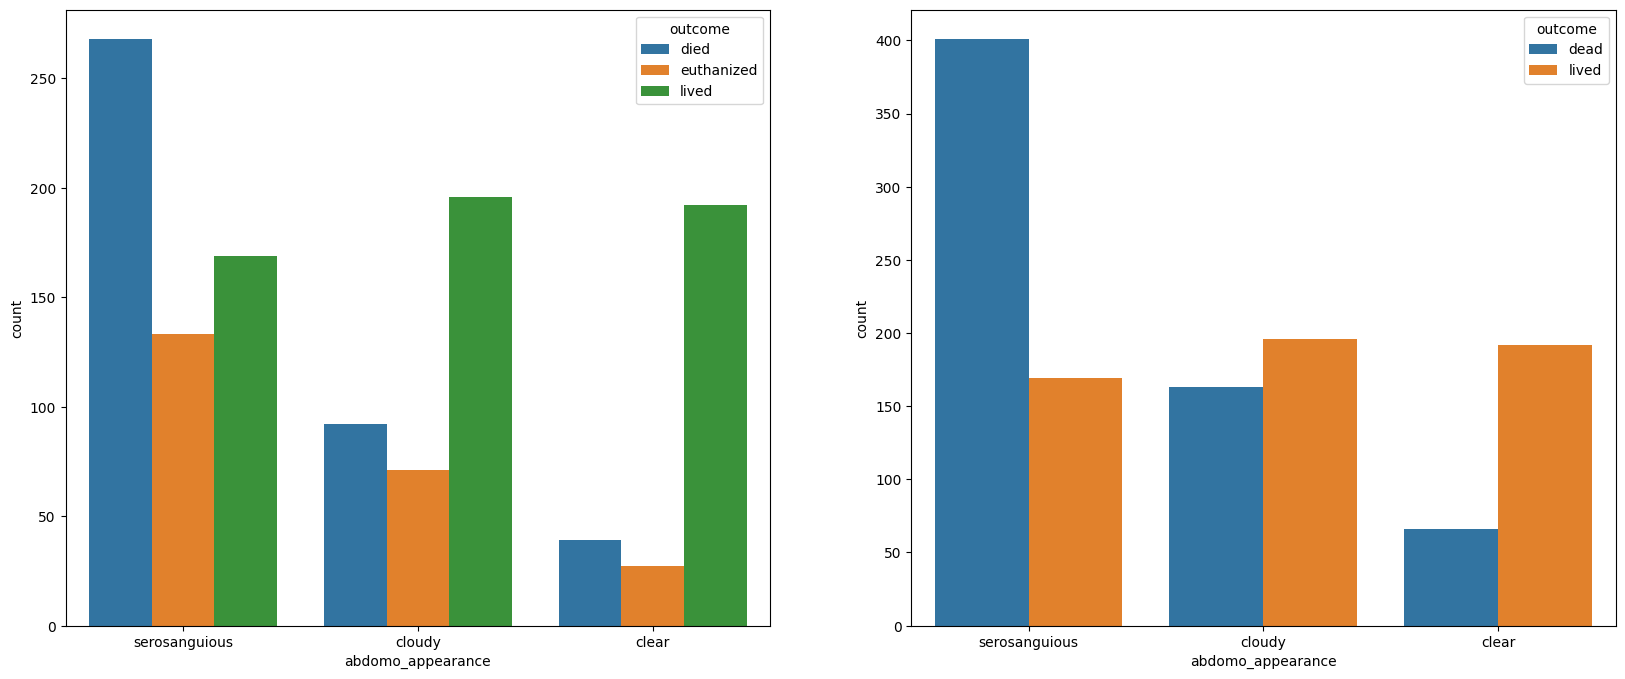

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
sns.countplot(data=train, x="abdomo_appearance", hue="outcome", ax=ax1)
sns.countplot(data=train_lived_died, x="abdomo_appearance", hue="outcome", ax=ax2)
plt.show()

<Axes: xlabel='pulse', ylabel='Count'>

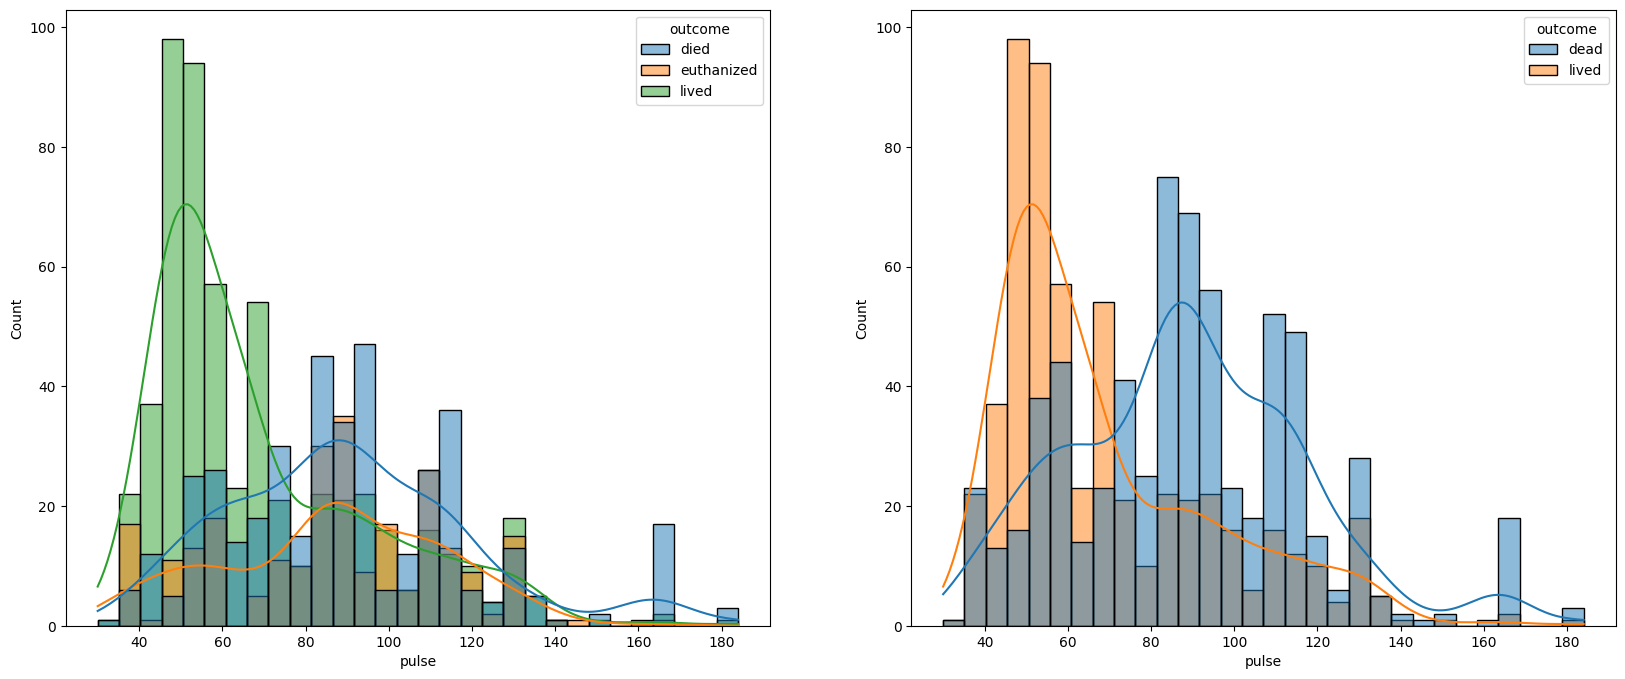

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
sns.histplot(data=train, x="pulse", hue="outcome", kde=True, bins=30, ax=ax1)
sns.histplot(data=train_lived_died, x="pulse", hue="outcome", kde=True, bins=30, ax=ax2)

<Axes: xlabel='packed_cell_volume', ylabel='Count'>

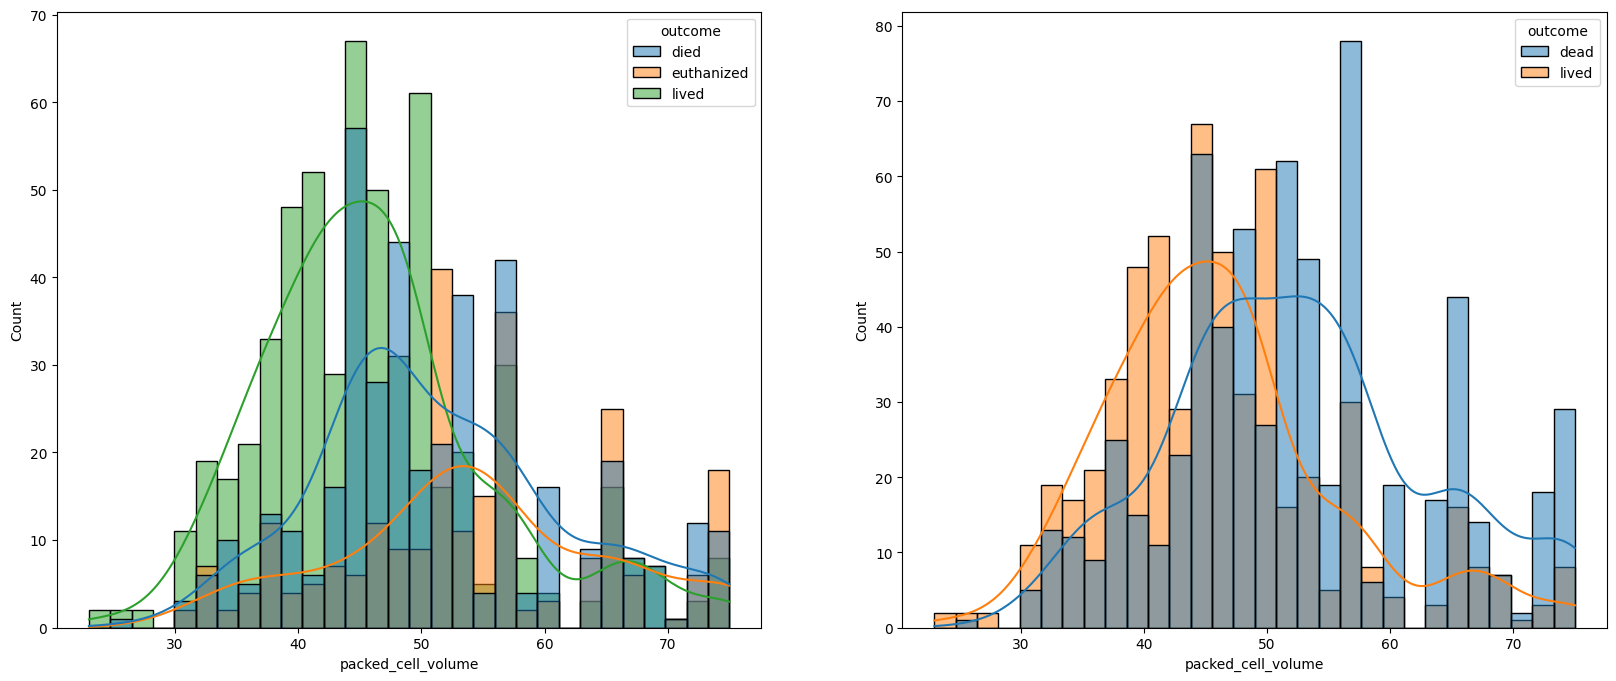

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
sns.histplot(data=train, x="packed_cell_volume", hue="outcome", kde=True, bins=30, ax=ax1)
sns.histplot(data=train_lived_died, x="packed_cell_volume", hue="outcome", kde=True, bins=30, ax=ax2)

<Axes: xlabel='rectal_temp', ylabel='Count'>

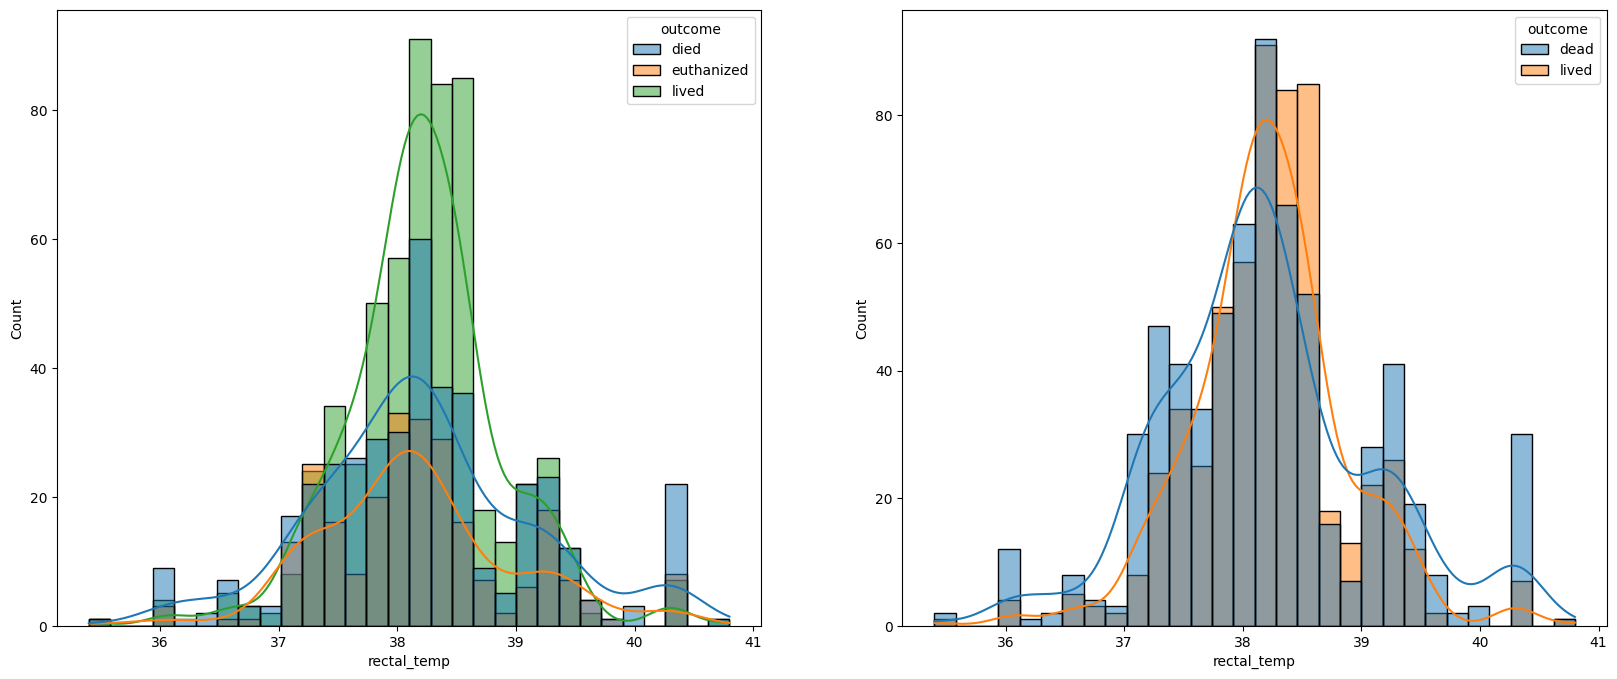

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
sns.histplot(data=train, x="rectal_temp", hue="outcome", kde=True, bins=30, ax=ax1)
sns.histplot(data=train_lived_died, x="rectal_temp", hue="outcome", kde=True, bins=30, ax=ax2)

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1235 entries, 0 to 1234
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   object 
 1   age                    1235 non-null   object 
 2   hospital_number        1235 non-null   int64  
 3   rectal_temp            1235 non-null   float64
 4   pulse                  1235 non-null   float64
 5   respiratory_rate       1235 non-null   float64
 6   temp_of_extremities    1196 non-null   object 
 7   peripheral_pulse       1175 non-null   object 
 8   mucous_membrane        1214 non-null   object 
 9   capillary_refill_time  1229 non-null   object 
 10  pain                   1191 non-null   object 
 11  peristalsis            1215 non-null   object 
 12  abdominal_distention   1212 non-null   object 
 13  nasogastric_tube       1155 non-null   object 
 14  nasogastric_reflux     1214 non-null   object 
 15  nasogastr

on va essayer avec une seule feature, ici le pulse

In [27]:
y = train.outcome
X = train[['pulse']]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
randomForest = RandomForestClassifier()

In [32]:
randomForest.fit(X_train, y_train)

RandomForestClassifier()

In [33]:
y_predict = randomForest.predict(X_test)

In [39]:
y_score = randomForest.fit(X_train, y_train).predict_proba(X_test)

In [40]:
from sklearn.preprocessing import LabelBinarizer

In [41]:
label_binarize = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarize.transform(y_test)
y_onehot_test.shape

(247, 3)

In [44]:
label_binarize.transform(["euthanized"])

array([[0, 1, 0]])

ROC curve showing a specific class

In [45]:
class_of_interest = "lived"
class_id = np.flatnonzero(label_binarize.classes_ == class_of_interest)[0]
class_id

2

In [46]:
from sklearn.metrics import RocCurveDisplay

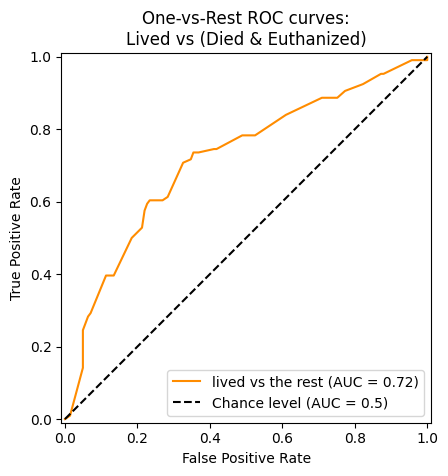

In [47]:
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\nLived vs (Died & Euthanized)",
)


In [35]:
randomForest.score(X_test, y_test) # ça c'est moi et le score ressemble au chance level

0.5344129554655871

In [48]:
print(f"y_score:\n{y_score[0:2,:]}")
print()
print(f"y_score.ravel():\n{y_score[0:2,:].ravel()}")

y_score:
[[0.16437451 0.41068692 0.42493857]
 [0.14408998 0.34074252 0.5151675 ]]

y_score.ravel():
[0.16437451 0.41068692 0.42493857 0.14408998 0.34074252 0.5151675 ]


In a multi-class classification setup with highly imbalanced classes, micro-averaging is preferable over macro-averaging. In such cases, one can alternatively use a weighted macro-averaging, not demoed here.

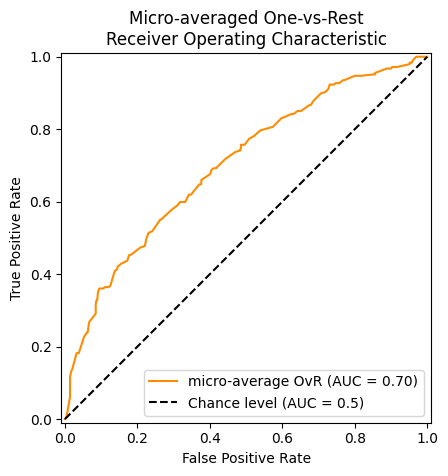

In [49]:
display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

In [65]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.70


On va essayer avec plus de features

In [59]:
y = train.outcome
X_enco = train_encoded[['pulse', 'temp_of_extremities', 'peristalsis', 'abdomo_appearance', 'packed_cell_volume']]

In [60]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_enco, y, test_size = 0.2)

In [61]:
y_score2 = randomForest.fit(X_train2, y_train2).predict_proba(X_test2)

In [62]:
label_binarize_2 = LabelBinarizer().fit(y_train2)
y_onehot_test_2 = label_binarize_2.transform(y_test2)
y_onehot_test_2.shape

(247, 3)

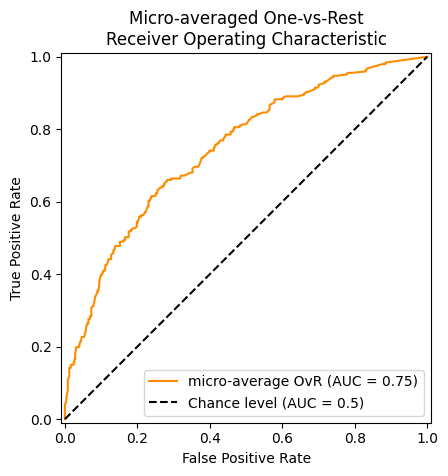

In [63]:
display = RocCurveDisplay.from_predictions(
    y_onehot_test_2.ravel(),
    y_score2.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

In [64]:
micro_roc_auc_ovr2 = roc_auc_score(
    y_test2,
    y_score2,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr2:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.75


In [66]:
y_predict2 = randomForest.predict(X_test2)

In [67]:
c_matrix = confusion_matrix(y_test2, y_predict2)
c_report = classification_report(y_test2, y_predict2)
c_matrix

array([[33, 13, 30],
       [18, 23, 14],
       [23, 12, 81]])

In [69]:
print(c_report)

              precision    recall  f1-score   support

        died       0.45      0.43      0.44        76
  euthanized       0.48      0.42      0.45        55
       lived       0.65      0.70      0.67       116

    accuracy                           0.55       247
   macro avg       0.52      0.52      0.52       247
weighted avg       0.55      0.55      0.55       247

